**Importation**

In [2]:
#Scikit update warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# librairies générales
import pandas as pd
import time
import numpy as np

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairie scikit-learn
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# classe pour afficher proprement les paramètres d'un classifieur
class Result_Parameters:
     def __init__(self,name, score, parameters):
         self.name = name
         self.score = score
         self.parameters = parameters
     def __repr__(self):
         return repr((self.name, self.score, self.parameters))

# classe pour afficher proprement les résultats d'une classification
class Result:
     def __init__(self,name, scoremean, stdresult,timespent):
         self.name = name
         self.scoremean = scoremean
         self.stdresult = stdresult
         self.timespent = timespent
     def __repr__(self):
         return repr((self.name, self.scoremean, self.stdresult,self.timespent))


# fonction utilisée pour l'affichage de la matrice de confusion
def plot_confusion_matrix(confusionmatrix, classes):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(8, 5))
 
    plt.title("Matrice de confusion")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(confusionmatrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'},fmt='g')
 
    ax.set_xticklabels(classes,rotation=45)
    ax.set_yticklabels(classes,rotation=0)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.show()
    plt.close()   
    
# fonction qui affiche le classification report et la matrice de confusion
def MyshowAllScores(y_test,y_pred):
  classes= np.unique(y_test)
  print("Accuracy : %0.3f"%(accuracy_score(y_test,y_pred)))
  print("Classification Report")
  print(classification_report(y_test,y_pred,digits=5))    
  cnf_matrix = confusion_matrix(y_test,y_pred)
  plot_confusion_matrix(cnf_matrix, classes)


# fonction qui teste un ensemble de pipeline et affiche les meilleurs résultats triés par score    
def MyTestPipelines(models,X,y,score='accuracy'):
  seed = 7        
  allresults = []
  results = []
  names = []
  for name,model in models:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=score)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
  allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

  # affichage des résultats
  print ('\nLe meilleur resultat : ')
  print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

  print ('Tous les résultats : \n')
  for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')
  return allresults      


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vivap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vivap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vivap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Chargement dataset**

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd /content/gdrive/My Drive/Notebooks/Poncelet_IA


names=["tweet_id", "relevancy", "keyword", "text"]

df_disaster = pd.read_csv("disaster_tweet_cleaned_0.csv", usecols=[0, 5, 8, 10], names=names)
df_disaster_equil = pd.read_csv("disaster_tweet_cleaned_7.csv", usecols=[0, 5, 8, 10], names=names)

print("Nombre d'occurrences par classe (original) :\n",df_disaster['relevancy'].value_counts())
print("")
print("Nombre d'occurrences par classe (equilibré):\n",df_disaster_equil['relevancy'].value_counts())
#print("Nombre d'occurrences par classe : \n",df_disaster['keyword'].value_counts())

Nombre d'occurrences par classe (original) :
 Not Relevant    6158
Relevant        4615
Name: relevancy, dtype: int64

Nombre d'occurrences par classe (equilibré):
 Not Relevant    4680
Relevant        4615
Name: relevancy, dtype: int64


**Preprocess**

In [4]:
import re
import emoji

# Cette fonction ne prends en charge que les lettres latines
def MyCleanText(X,
               removeEmoji=False, #Emojis
               removeHashtags=False, #Suppression hashtags
              ):

    sentence=str(X)

    #Substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    #Suppression mentions et url
    sentence = re.sub(r"(?:\@[a-zA-Z\_0-9]+|https?\:\/\/\S+)", "", sentence)

    # decoupage en mots
    tokens = word_tokenize(sentence)

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]

    #Suppression hashtag
    if removeHashtags:
      sentence = re.sub(r"\B(\#[a-zA-Z0-9\_]+\b)", "", sentence)

    #Suppression emojis
    if removeEmoji:
      sentence = emoji.get_emoji_regexp().sub(u'', sentence) #On utilise le package emojis car les règles unicodes des emojis changent constamment

    return sentence

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removeEmoji=False, #Emojis
                 removeHashtags=False, #Suppression hashtags
                ):
        
        self.removeEmoji=removeEmoji
        self.removeHashtags=removeHashtags
        

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,
                            removeEmoji=self.removeEmoji,
                            removeHashtags=self.removeHashtags) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'removeEmoji':self.removeEmoji,
            'removeHashtags':self.removeHashtags
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self

**Test pré-traitement**

In [5]:
s = "2020 can't get any worse 💕👭👙 #ihate2020 ぼくの名前は　👨‍👩‍👦‍👦 @bestfriend https://t.co　ッッッッッ"

print("Normal :", MyCleanText(s))
print("Hashtags :", MyCleanText(s, removeHashtags=True))
print("Emoji :", MyCleanText(s, removeEmoji=True))
print("Both : ", MyCleanText(s, removeHashtags=True, removeEmoji=True))

Normal : 2020 can't get any worse 💕👭👙 #ihate2020 ぼくの名前は 👨‍👩‍👦‍👦   ッッッッッ
Hashtags : 2020 can't get any worse 💕👭👙  ぼくの名前は 👨‍👩‍👦‍👦   ッッッッッ
Emoji : 2020 can't get any worse  #ihate2020 ぼくの名前は    ッッッッッ
Both :  2020 can't get any worse   ぼくの名前は    ッッッッッ


**Test de plusieurs pré-traitement**

In [6]:
# pipeline de l'utilisation de TfidfVectorizer sur le texte presque sans traitement
TFIDF_brut = Pipeline ([("cleaner", TextNormalizer()), 
                    ("tfidf_vectorizer", TfidfVectorizer()),
                    ('MultinomialNB',MultinomialNB())])

TFIDF_emoji = Pipeline ([("cleaner", TextNormalizer(removeEmoji=True)), 
                    ("tfidf_vectorizer", TfidfVectorizer()),
                    ('MultinomialNB',MultinomialNB())])

TFIDF_emoji_hashtag = Pipeline ([("cleaner", TextNormalizer(removeEmoji=True,removeHashtags=True)), 
                    ("tfidf_vectorizer", TfidfVectorizer()),
                    ('MultinomialNB',MultinomialNB())])

# Liste de tous les modèles à tester
all_models = [
    ("TFIDF_brut", TFIDF_brut),
    ("TFIDF_emoji", TFIDF_emoji),
    ("TFIDF_emoji_hashtag", TFIDF_emoji_hashtag)
]

In [6]:
from sklearn.model_selection import cross_val_score

#dill utilise les mêmes interfaces que Pickle, et permet d'utiliser joblib pour paralléliser
import dill as pickle

# Non équilibré
X=df_disaster.text
y=df_disaster.relevancy

#Evaluation des différents pipelines non équilibré
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5, n_jobs=16).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print("Non équilibré : ")
print (tabulate(scores, floatfmt=".3f", headers=("Pipeline", 'Score')))
print("")

# Equilibré
X=df_disaster_equil.text
y=df_disaster_equil.relevancy

#Evaluation des différents pipelines équilibré
unsorted_scores = [(name, cross_val_score(model, X, y, cv=5, n_jobs=16).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print("Equilibré : ")
print (tabulate(scores, floatfmt=".3f", headers=("Pipeline", 'Score')))

Non équilibré : 
Pipeline               Score
-------------------  -------
TFIDF_emoji            0.728
TFIDF_brut             0.728
TFIDF_emoji_hashtag    0.722

Equilibré : 
Pipeline               Score
-------------------  -------
TFIDF_brut             0.712
TFIDF_emoji            0.712
TFIDF_emoji_hashtag    0.703


**Choix du meilleur classifier**

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier


# creation du tableau des différents classifieur 


models = []
#models.append(('CART', DecisionTreeClassifier())) #SLOW
#models.append(('RF', RandomForestClassifier())) #SLOW
#models.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis())) #SLOW
#models.append(('RidgeClassifier', RidgeClassifier())) #Slow but not bad

models.append(('ComplementNB', ComplementNB())) #Pas mieux, même si déséquilibré, fast
models.append(('KNN', KNeighborsClassifier())) #Fast
models.append(('MultinomialNB',MultinomialNB())) #Fast
models.append(('LinearSVC', LinearSVC())) #Fast but meh
models.append(('LR', LogisticRegression(solver='lbfgs', n_jobs=20))) #Slowish 60 seconds
models.append(('Perceptron', Perceptron(n_jobs=20))) #Fast
models.append(('BernouilliNB', BernoulliNB())) #Fast and good
models.append(('NearestCentroid', NearestCentroid())) #Fast but bad
models.append(('SGDClassifier', SGDClassifier(n_jobs=20))) #Fast and good
models.append(('PassiveAggressiveClassifier', PassiveAggressiveClassifier(n_jobs=20))) #Fast but bad




**Exécution des classifiers**

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []

X = df_disaster.text
y = df_disaster.relevancy

# Nous appliquons les pré-traitements sur X

text_normalizer=TextNormalizer(removeEmoji=True)  
# appliquer fit.transform pour réaliser les pré-traitements sur X
X_cleaned=text_normalizer.fit_transform(X)

# pour l'enchainer avec un tf-idf et obtenir une matrice
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(X_cleaned).toarray()

# attention ici il faut passer features dans cross_val_score plutôt que X
    
for name,model in models:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score, n_jobs=20)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #ICI #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

# affichage des résultats
print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

print ('Tous les résultats : \n')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')
    
####tester naive base, random forest classifier, svm, (k neighbor trop lent)

Evaluation de  ComplementNB
ComplementNB : 0.800 (0.008) in 12.966 s
Evaluation de  KNN
KNN : 0.777 (0.008) in 30.433 s
Evaluation de  MultinomialNB
MultinomialNB : 0.803 (0.015) in 9.071 s
Evaluation de  LinearSVC
LinearSVC : 0.800 (0.005) in 7.749 s
Evaluation de  LR
LR : 0.809 (0.011) in 65.654 s
Evaluation de  Perceptron
Perceptron : 0.760 (0.023) in 17.402 s
Evaluation de  BernouilliNB
BernouilliNB : 0.805 (0.009) in 14.891 s
Evaluation de  NearestCentroid
NearestCentroid : 0.751 (0.014) in 10.935 s
Evaluation de  SGDClassifier
SGDClassifier : 0.806 (0.008) in 23.214 s
Evaluation de  PassiveAggressiveClassifier
PassiveAggressiveClassifier : 0.765 (0.010) in 34.882 s

Le meilleur resultat : 
Classifier :  LR  accuracy : 0.809  (0.011)  en 65.654   s

Tous les résultats : 

Classifier :  LR  accuracy : 0.809  (0.011)  en 65.654   s
Classifier :  SGDClassifier  accuracy : 0.806  (0.008)  en 23.214   s
Classifier :  BernouilliNB  accuracy : 0.805  (0.009)  en 14.891   s
Classifier :  

**Paramètrage fin**
> On va utiliser MultinomialNB, on passe aux hyperparamètres, qui offre le meilleur compromis résultat/temps



In [25]:
X = df_disaster.text
y = df_disaster.relevancy

# Nous appliquons les pré-traitements sur X

text_normalizer=TextNormalizer(removeEmoji=True)  
# appliquer fit.transform pour réaliser les pré-traitements sur X
X_cleaned=text_normalizer.fit_transform(X)

# pour l'enchainer avec un tf-idf et obtenir une matrice
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(X_cleaned).toarray()

In [26]:
modelsNB = []
score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []

#La seed donne toujours le même découpage ? Est-ce voulu ?

modelsNB.append(('MultinomialNB_default',MultinomialNB()))
modelsNB.append(('MultinomialNB_class_prior',MultinomialNB(fit_prior=False, class_prior=[0.35, 0.38])))
modelsNB.append(('MultinomialNB_alpha06',MultinomialNB(alpha=0.6)))
modelsNB.append(('MultinomialNB_alpha06_fit',MultinomialNB(fit_prior=False, alpha=0.6)))
modelsNB.append(('MultinomialNB_alpha0',MultinomialNB(alpha=0.)))
modelsNB.append(('MultinomialNB_alpha2',MultinomialNB(alpha=2.)))
modelsNB.append(('MultinomialNB_fit_prior',MultinomialNB(fit_prior=False)))

# attention ici il faut passer features dans cross_val_score plutôt que X
    
for name,model in modelsNB:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score, n_jobs=20)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #ICI #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

# affichage des résultats
print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

print ('Tous les résultats : \n')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')

Evaluation de  MultinomialNB_default
MultinomialNB_default : 0.803 (0.015) in 9.347 s
Evaluation de  MultinomialNB_class_prior
MultinomialNB_class_prior : 0.798 (0.006) in 8.765 s
Evaluation de  MultinomialNB_alpha06
MultinomialNB_alpha06 : 0.804 (0.012) in 8.870 s
Evaluation de  MultinomialNB_alpha06_fit
MultinomialNB_alpha06_fit : 0.800 (0.006) in 7.825 s
Evaluation de  MultinomialNB_alpha0
MultinomialNB_alpha0 : 0.759 (0.011) in 7.633 s
Evaluation de  MultinomialNB_alpha2
MultinomialNB_alpha2 : 0.796 (0.015) in 8.182 s
Evaluation de  MultinomialNB_fit_prior
MultinomialNB_fit_prior : 0.800 (0.008) in 7.284 s

Le meilleur resultat : 
Classifier :  MultinomialNB_alpha06  accuracy : 0.804  (0.012)  en 8.870   s

Tous les résultats : 

Classifier :  MultinomialNB_alpha06  accuracy : 0.804  (0.012)  en 8.870   s
Classifier :  MultinomialNB_default  accuracy : 0.803  (0.015)  en 9.347   s
Classifier :  MultinomialNB_fit_prior  accuracy : 0.800  (0.008)  en 7.284   s
Classifier :  Multinomi

**Matrice de confusion**

pipeline créé
Accuracy : 0.810
Classification Report
              precision    recall  f1-score   support

Not Relevant    0.78581   0.91968   0.84749      1855
    Relevant    0.85957   0.66231   0.74815      1377

    accuracy                        0.81002      3232
   macro avg    0.82269   0.79099   0.79782      3232
weighted avg    0.81724   0.81002   0.80517      3232



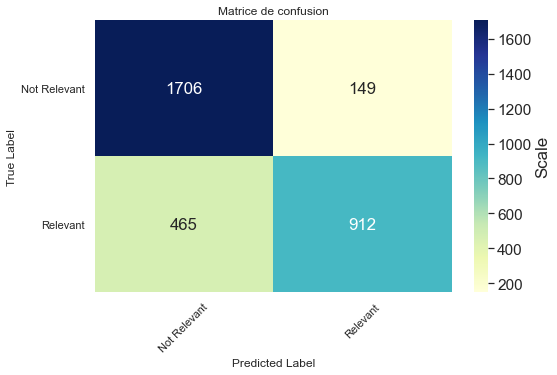

In [28]:
from sklearn.model_selection import train_test_split
X = df_disaster.text
y = df_disaster.relevancy

# Création d'un jeu d'apprentissage et de test
trainsize=0.7 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize=0.3
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=trainsize, random_state=seed, test_size=testsize)

# création du pipeline en ajoutant le classifier
pipe = Pipeline([('cleaner', TextNormalizer(removeEmoji=True)), 
                 ('tfidf_vectorizer', TfidfVectorizer(lowercase=True)), #Deja True par défaut
                 ('MultinomialNB',MultinomialNB(alpha=0.6))])
pipe.fit(X_train,y_train)

print("pipeline créé")

from sklearn import metrics

y_pred = pipe.predict(X_test)

MyshowAllScores(y_test,y_pred)

## Sauvegarde du modèle

In [31]:
X=df_disaster.text
y=df_disaster.relevancy

pipeline=Pipeline([("cleaner", TextNormalizer(removeEmoji=True)),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('MultinomialNB',MultinomialNB(alpha=0.6))])
pipeline.fit(X,y)
filename='disasterRelevantModelMultiNB_alpha06.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))

Sauvegarde du modèle dans  disasterRelevantModelMultiNB_alpha06.pkl
